In [8]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
import numpy as np
from scipy.sparse import csr_array, lil_array
import matplotlib.pyplot as plt
import pandas as pd
import math
import pickle
import time
import datetime
import random
from pprint import pprint

from SVD import Metrics, SVDPredictor, LogisticSVD, FastLogisticSVD
from RecData import RecData

In [2]:
# recs = pd.read_csv('data/recommendations.csv')
recs = pd.read_csv('data/pruned.csv')

# Remove old ratings
recs = recs.sort_values(by=['date'], ascending=False)
recs.drop_duplicates(subset= ['app_id', 'user_id'], inplace=True) 

USED_COLS = ['app_id', 'is_recommended', 'user_id']
recs = recs[USED_COLS]

item_data = pd.read_csv('data/games.csv')
titles = item_data[['app_id', 'title']]

print("Shape:", recs.shape)
recs.head()

Shape: (1482532, 3)


,app_id,is_recommended,user_id
279261,271590,True,2706940
968812,698540,True,3892918
965466,1085510,True,4590796
965540,1949960,False,3058171
1373726,1088850,True,2018014


In [3]:
random.seed(42)
np.random.seed(42)

rec_data = RecData()
rec_data.create_from_dataframe(recs)
rec_data.set_titles(titles)

del recs

print("Creating splits...")
train_data, test = rec_data.train_test_split(test_size=0.2)
print("First split done.")
train_data, val = train_data.train_test_split(test_size=0.2)
print("Done creating splits.")

Creating utility matrix...
Done utility matrix.
Creating splits...
First split done.
Done creating splits.


In [4]:
rec_data._num_users

63175

In [5]:
# random.seed(42)
# np.random.seed(42)

# rec_data = RecData()
# rec_data.create_from_dataframe(recs)
# rec_data.set_titles(titles)

# del recs

# print("Creating splits...")
# train_data, val, test = rec_data.leave_k_out_split(k=1)
# print("Done creating splits.")

In [6]:
del item_data
del titles

Epoch 0
Training error: 0.6921413393589864
Validation error: 0.6922878074922371
Time: 5.65 seconds


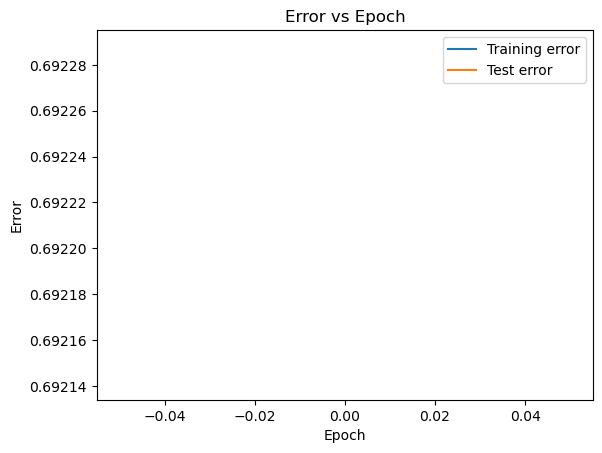

Test rmse 0.49957013121320354


In [7]:
EPOCHS = 1

random.seed(42)
np.random.seed(42)

# Fit and predict with svd
svd_predictor = FastLogisticSVD(
    train_data.get_num_users(), train_data.get_num_items(), 2, k=20, 
    learning_rate=0.1, C=0.02)
svd_predictor.fit(train_data.get_matrix(), EPOCHS, validation_set=val, early_stop=False)

# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

In [ ]:
csr_array(svd_predictor._M).indptr

In [13]:
csr_array(svd_predictor._M).indices

array([   0,  236,  309, ..., 1415, 1595, 1846])

In [ ]:
# Ensure file exists
model_dir = model_dir = "saved_models/{}-{}-{}-{}-{}-{}_{}".format(
    *(time.localtime()[:6] + (round(rmse, 4), ))).replace(".", "-") + ".pkl" 
file = open(model_dir, 'a')
file.close()

# Save model
print("Saving model...")
with open(model_dir, 'wb') as file:
    pickle.dump([svd_predictor, rec_data, train_data, val, test], file)
print("Done saving model.")

In [30]:
svd_predictor.continue_fit(5, early_stop=False)

Epoch 0/Training error: 0.4598560610046211/Validation error: 0.4828452165798823/Time: 40.86 seconds
Epoch 1/Training error: 0.3865513665728606/Validation error: 0.41591767711048294/Time: 44.88 seconds
Epoch 2/Training error: 0.37002277161721536/Validation error: 0.40241943064326735/Time: 40.99 seconds
Epoch 3/Training error: 0.3615596452176083/Validation error: 0.3972743308606597/Time: 31.79 seconds
Epoch 4/Training error: 0.3519719172166776/Validation error: 0.39279995274006024/Time: 32.47 seconds


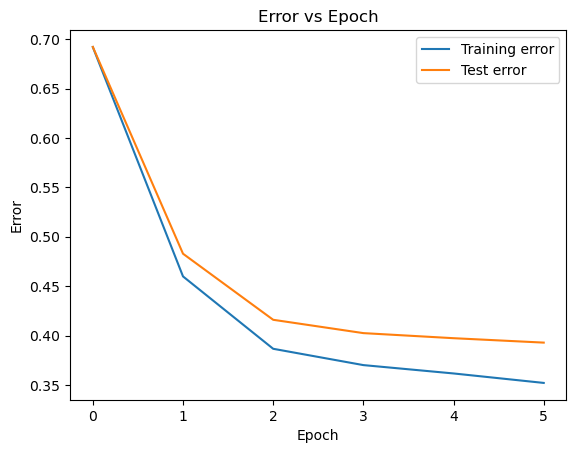

In [31]:
# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

In [32]:
j = 18
# Test top-n list for user j
top_n = svd_predictor.top_n(j, 20)
print("Predicted top n:")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

# User j true top n list
print("True top n:")
true_top = rec_data.top_n(j, 5000)
pprint([rec_data.index_to_title(index) for _, index in true_top])

Predicted top n:
[(0.9724143407528977, 'Unavowed'),
 (0.9719591144955007, 'Walkabout Mini Golf VR'),
 (0.97099287534754, 'Choice of Robots'),
 (0.9708463940822772, 'Persona 5 Royal'),
 (0.9707767052685625, 'Ultimate Chicken Horse'),
 (0.9697631683350322, 'Monolith'),
 (0.9684233657828057, 'The Jackbox Party Pack 7'),
 (0.968277198439032, 'Mafia II (Classic)'),
 (0.9680446878611991, 'People Playground'),
 (0.9678445500154024, 'Pentiment'),
 (0.9676326918896735, 'Thief™ II: The Metal Age'),
 (0.9672739687635137, 'Lost Judgment'),
 (0.9672021761228569, 'STAR WARS™ Battlefront (Classic 2004)'),
 (0.9662369989522029, 'Streets of Rogue'),
 (0.9662184151319373, 'Terraria'),
 (0.966107848663054, 'FINAL FANTASY IV'),
 (0.9659740418289244, 'DOOM (1993)'),
 (0.9659696131994129, 'Return to Monkey Island'),
 (0.9659418044052771, 'A Hat in Time'),
 (0.9657888435859024, 'Half-Life 2')]
True top n:
['Portal',
 'Cyberpunk 2077',
 "Mirror's Edge™ Catalyst",
 'Stray',
 'Warhammer 40000: Space Marine - An

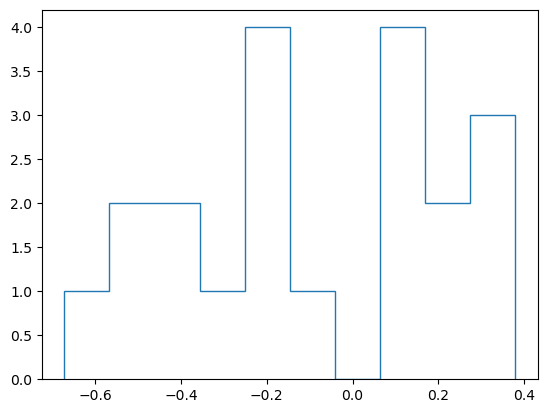

In [33]:
values, bins = np.histogram(svd_predictor._user_features[0, :])
plt.stairs(values, bins)
plt.show()

In [34]:
rec_data.search_title('mortal')

[('Noel the Mortal Fate S1-7', 2177),
 ('Mortal Kombat X', 1045),
 ('IMMORTALITY', 803),
 ('Mortal Shell', 775),
 ('鬼谷八荒 Tale of Immortal', 1936),
 ('Dark Deception: Monsters & Mortals', 856),
 ('Mortal Online 2', 1241),
 ('Mortal Kombat\xa011', 773)]

In [35]:
# prefs = [(606, 1), (1628, 1), (391, 0), (1330, 0), (500, 0), (709, 1), (840, 0), 
#          (58, 1), (456, 1), (153, 0), (158, 0), (1160, 0), (761, 0),
#                               (1771, 0), (544, 0), (312, 0), (277, 0)]
prefs = [(5, 1), (229, 1), (966, 0)]
pprint([(index, rec_data.index_to_title(index), pref) for index, pref in prefs])
prefs = rec_data.create_prefs(prefs)    

[(5, 'NARAKA: BLADEPOINT', 1),
 (229, 'Highrise City', 1),
 (966, 'Steel Division 2', 0)]


In [36]:
svd_predictor._partial_batch_size = int(0)
start_time = time.time()
svd_predictor.partial_fit(prefs)
print("Completed partial fit in", time.time() - start_time, "seconds")

AttributeError: 'LogisticSVD' object has no attribute '_epochs'

In [ ]:
top_n = svd_predictor.top_n(svd_predictor._num_users - 1, 20)
print("Predicted top n")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])